# Conservation plots

## Preliminaries

### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%run _color_tools.ipynb

The color palette is saved in the global variable, C
C = color_palette(blue='#0077bb', green='#009988', orange='#ee7733', red='#cc3311', light_blue='#33bbee', pink='#ee3377', grey='#bbbbbb', black='#000000')


## Load and clean data

In [2]:
%%bash

# Download datasets from UKB RAP
dx download outputs/stats_hmc.tsv -f -o ../outputs/stats_hmc.tsv
dx download outputs/stats_phylop.tsv -f -o ../outputs/stats_phylop.tsv
dx download outputs/stats_pext.tsv -f -o ../outputs/stats_pext.tsv

In [3]:
# Order and name the region and constraint variables
region_order = ["transcript", "nmd_target", "long_exon", "distal_nmd"]
region_labels = ["Whole transcript", "NMD target", "Long exon", "Distal"]
constraint_order = ["all", "constrained", "unconstrained"]
constraint_labels = ["All", "Constrained", "Unconstrained"]

In [4]:
metrics = ["phylop", "hmc", "pext"]
paths = [f"../outputs/stats_{x}.tsv" for x in metrics]


def get_stats(path):

    # Read data
    df = pd.read_csv(path, sep="\t")

    # Drop start proximal sites
    df = df[df["region"] != "start_proximal"]

    # Order the data by region
    df["region"] = pd.Categorical(df["region"], categories=region_order, ordered=True)
    df = df.sort_values("region", ascending=False)

    return df


phylop, hmc, pext = [get_stats(p) for p in paths]

## Horizontal bar plot

In [15]:
colors = [C.grey, C.red, C.blue]

In [16]:
cm = 1 / 2.54  # cm to inches converter

In [77]:
def plot_metrics_by_region(
    df,
    ax,
    metric="phylop",
    constraint="constrained",
    xlim=False,
    yticks=False,
    legend=False,
    title=False,
):
    # Define colors
    color = C.black
    if constraint == "constrained":
        color = C.red
    if constraint == "unconstrained":
        color = C.blue
    if constraint == "all":
        color = C.grey

    # Subset the data
    df = df[df["constraint"] == constraint]

    # Horizontal bar plot
    n = len(df)
    y = np.arange(n)
    x = df[metric]
    xerr = df["ci95"]

    ax.barh(
        y=y * 1 / n,
        height=1 / (n + 1),
        width=x,
        color=color,
        # label=l,
        xerr=xerr,
    )

    ax.set_yticks(ticks=y * 1 / n, labels=reversed(region_labels))
    ax.tick_params(axis="y", length=0)

    if legend:
        ax.set_title(legend, loc="left", c=color)
        
    if title:
        ax.set_title(title)

    ax.spines["left"].set_position(("outward", 5))
    ax.spines["left"].set_visible(False)

    return None

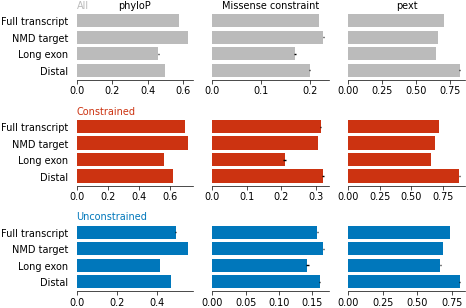

In [78]:
fig, axs = plt.subplots(
    3,
    3,
    figsize=(12 * cm, 8 * cm),
    layout="constrained",
    gridspec_kw={"hspace": 0.1},
    sharey=True,
)
axs = axs.flatten()

plot_metrics_by_region(phylop, axs[0], "phylop", "all", legend="All", title="phyloP")
plot_metrics_by_region(phylop, axs[3], "phylop", "constrained", legend="Constrained")
plot_metrics_by_region(
    phylop, axs[6], "phylop", "unconstrained", legend="Unconstrained"
)

plot_metrics_by_region(hmc, axs[1], "hmc", "all", title="Missense constraint")
plot_metrics_by_region(hmc, axs[4], "hmc", "constrained")
plot_metrics_by_region(hmc, axs[7], "hmc", "unconstrained")

plot_metrics_by_region(pext, axs[2], "pext", "all", title="pext")
plot_metrics_by_region(pext, axs[5], "pext", "constrained")
plot_metrics_by_region(pext, axs[8], "pext", "unconstrained")

# Set x limits

# Add panel labels
Axes = [axs[x] for x in [0, 3, 6]]


In [6]:
def barh_plot(df, metric, xlim):

    fig, axs = plt.subplots(
        3, 1, figsize=(6, 5), layout="constrained", gridspec_kw={"hspace": 0.1}
    )

    # Refresh the subsets
    _all = df[df["constraint"] == "all"]
    cons = df[df["constraint"] == "constrained"]
    nonc = df[df["constraint"] == "unconstrained"]

    n = len(_all)
    y = np.arange(n)

    _x = [x[metric] for x in [_all, cons, nonc]]
    _xerr = [x["ci95"] for x in [_all, cons, nonc]]

    for ax, x, xerr, c, l in zip(axs, _x, _xerr, colors, constraint_labels):
        bars = ax.barh(
            y=y * 1 / n, height=1 / (n + 1), width=x, color=c, label=l, xerr=xerr
        )
        # y ticks have reversed label order (hbar plots low to high)
        ax.set_yticks(ticks=y * 1 / n, labels=reversed(region_labels))
        ax.set_xlim(xlim)
        ax.spines["left"].set_position(("outward", 10))
        # ax.spines["left"].set_visible(False)
        # ax.bar_label(bars, fmt="%.2g", color=c, padding=5)

    for ax in [axs[0], axs[1]]:
        ax.set_xticks([])
        ax.spines[["top", "bottom", "right"]].set_visible(False)

    axs[2].spines[["top", "right"]].set_visible(False)

    return fig, [ax for ax in axs]

In [7]:
def label_groups(axs, x, y):
    for ax, c, l in zip(axs, colors, constraint_labels):
        ax.text(
            x,
            y,
            s=l,
            color=c,
            horizontalalignment="left",
            verticalalignment="bottom",
        )

## phyloP

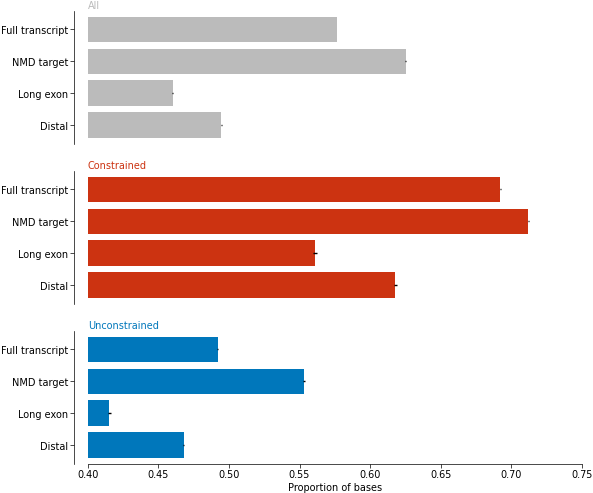

In [8]:
phylop_fig, phylop_axs = barh_plot(phylop, "phylop", xlim=(0.4, 0.75))

# Label groups
label_groups(phylop_axs, x=0.4, y=0.9)

# Set x labels
phylop_axs[2].set_xlabel("Proportion of bases")

# Save figure
plt.savefig("../plots/phylop_region_constraint.svg", format="svg")

## Homologous missense constraint

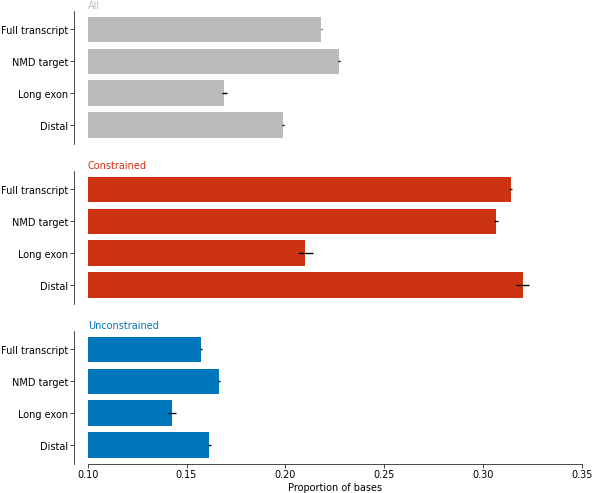

In [9]:
hmc_fig, hmc_axs = barh_plot(hmc, "hmc", xlim=(0.1, 0.35))

# Label groups
label_groups(hmc_axs, x=0.1, y=0.9)

# Set x labels
hmc_axs[2].set_xlabel("Proportion of bases")

# Save figure
plt.savefig("../plots/hmc_region_constraint.svg", format="svg")

## Proportion expressed across tissues

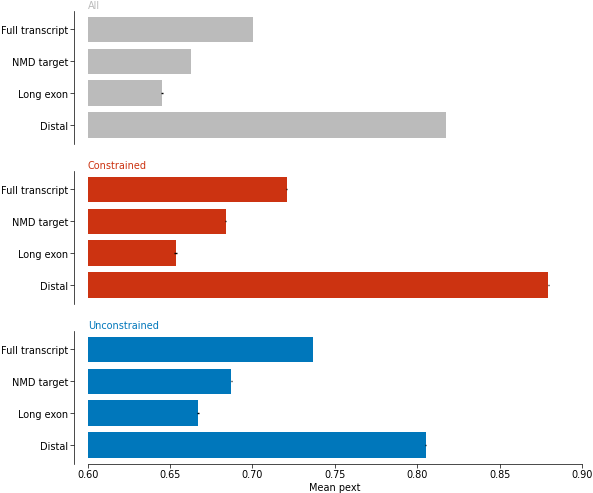

In [10]:
pext_fig, pext_axs = barh_plot(pext, "pext", xlim=(0.6, 0.9))

# Label groups
label_groups(pext_axs, x=0.6, y=0.9)

# Set x labels
pext_axs[2].set_xlabel("Mean pext")

# Save figure
plt.savefig("../plots/pext_region_constraint.svg", format="svg")